<a href="https://colab.research.google.com/github/george-kan/fastai/blob/main/Chapter14/Chapter_14_notes.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install --upgrade fastai
from fastai.vision.all import *
from fastai import *

File downloaded is broken. Remove /root/.fastai/archive/imagenette2-160.tgz and try again.


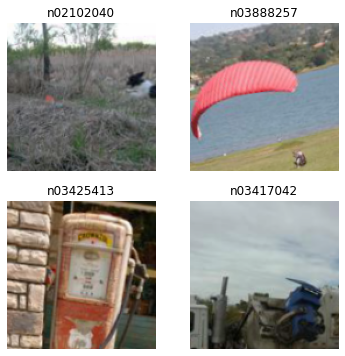

In [2]:
def get_data(url, presize, resize):
    path = untar_data(url)
    return DataBlock(
        blocks=(ImageBlock, CategoryBlock), get_items=get_image_files,
        splitter=GrandparentSplitter(valid_name = 'val'),
        get_y=parent_label, item_tfms=Resize(presize),
        batch_tfms=[*aug_transforms(min_scale=0.5, size=resize), Normalize.from_stats(*imagenet_stats)]
    ).dataloaders(path, bs = 128)

dls = get_data(URLs.IMAGENETTE_160, 160, 128)
dls.show_batch(max_n = 4)